In [1]:
# System
import os
import sys

# Maths
import numpy as np
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier

# Atoms
from ase.io import read, write

# Plotting
import matplotlib.pyplot as plt

# SOAP density utilities
sys.path.append('/home/helfrech/Tools/Toolbox/utils')
from soap import reshape_soaps, reshape_expansion
from soap import librascal_soap, compute_soap_density

# General utilities
from tqdm.auto import tqdm
import project_utils as utils

# Setup

In [2]:
# Load frameworks
deem_10k = read('../Raw_Data/DEEM_10k/DEEM_10000.xyz', index=':')
iza_230 = read('../Raw_Data/GULP/IZA_230/IZA_230.xyz', index=':')

In [3]:
deem_idxs = np.arange(0, len(deem_10k))
np.random.shuffle(deem_idxs)
n_deem_train = 9000
deem_train_idxs = deem_idxs[0:n_deem_train]
deem_test_idxs = deem_idxs[n_deem_train:]

iza_train_idxs = np.loadtxt('../Processed_Data/IZA_230/svm_train.idxs', dtype=int)
iza_test_idxs = np.loadtxt('../Processed_Data/IZA_230/svm_test.idxs', dtype=int)

In [4]:
iza_cantons = np.ones(len(iza_230), dtype=int)
deem_cantons = np.ones(len(deem_10k), dtype=int) * 2

In [5]:
species_list = np.unique([np.unique(frame.get_atomic_numbers()) for frame in deem_10k+iza_230]).tolist()
n_species = len(species_list)

# Compute SOAPs

In [6]:
contracted_basis = False

## Basis contraction

In [7]:
# Expansion hyperparameters
basis_hyperparameters = dict(
    radial_basis='DVR',
    max_radial=12,
    max_angular=9,
    interaction_cutoff=6.0,
    gaussian_sigma_type='Constant',
    gaussian_sigma_constant=0.3,
    cutoff_smooth_width=0.3,
)

basis_args = dict(
    center_species=[14],
    representation='SphericalExpansion',
    average=False,
    concatenate=True
)

In [8]:
if contracted_basis:
    
    n_max = basis_hyperparameters['max_radial']
    l_max = basis_hyperparameters['max_angular']
    
    batch_size = 100
    n_deem = len(deem_10k)
    n_batches = n_deem // batch_size
    if n_deem % batch_size > 0:
        n_batches += 1
    
    C = np.zeros((n_species, l_max + 1, n_max, n_max))
    v = np.zeros(C.shape[0:3])
    U = np.zeros(C.shape)

    n_centers = 0
    for i in tqdm(range(0, n_batches)):
        batch_frames = deem_10k[i * batch_size:(i + 1) * batch_size]
        batch_soaps = librascal_soap(
            batch_frames,
            **basis_hyperparameters,
            **basis_args,
            progress_bar=False
        )

        n_centers += len(batch_soaps)

        batch_soaps = reshape_expansion(
            batch_soaps, n_species, n_max, l_max, split_l=True
        )

        C += np.einsum('iaxlm,iaylm->alxy', batch_soaps, batch_soaps, optimize=True)

    C /= n_centers

    for a in range(0, C.shape[0]):
        for l in range(0, C.shape[1]):
            v_al, U_al = np.linalg.eigh(C[a, l])

            v_al = np.flip(v_al)
            U_al = np.flip(U_al, axis=1)

            v[a, l] = v_al
            U[a, l] = U_al
            
        print(np.cumsum(v[a, 0] / np.sum(v[a, 0])))

## SOAP with contracted basis

In [9]:
# SOAP hyperparameters
soap_hyperparameters = basis_hyperparameters.copy()
soap_hyperparameters.update(
    soap_type='RadialSpectrum',
    max_radial=12,
    normalize=False
)

soap_args = basis_args.copy()
soap_args.update(
    representation='SphericalInvariants',
    average=True,
)

if contracted_basis:
    projection_matrix = {
        species: np.moveaxis(
            U[s, 0:1, :, 0:soap_hyperparameters['max_radial']], 1, 2
        ).tolist() for s, species in enumerate(species_list)
    }

    spline_args = dict(
        optimization=dict(
            Spline=dict(accuracy=1.0E-8),
            RadialDimReduction=dict(
                projection_matrices=projection_matrix
            )
        )
    )
else:
    spline_args = {}

In [10]:
# Compute SOAPs
deem_soaps = librascal_soap(
    deem_10k,
    **soap_hyperparameters,
    **soap_args,
    **spline_args
)
iza_soaps = librascal_soap(
    iza_230,
    **soap_hyperparameters,
    **soap_args,
    **spline_args
)

# SVM

In [11]:
train_soaps = np.vstack((iza_soaps[iza_train_idxs], deem_soaps[deem_train_idxs]))
train_cantons = np.concatenate((iza_cantons[iza_train_idxs], deem_cantons[deem_train_idxs]))

test_soaps = np.vstack((iza_soaps[iza_test_idxs], deem_soaps[deem_test_idxs]))

In [12]:
train_class_weights = utils.balanced_class_weights(train_cantons)

In [13]:
parameter_grid = dict(svc__estimator__C = np.logspace(-3, 3, 7))
fit_params = {'norm_scaler__sample_weight': train_class_weights}

In [14]:
pipeline = Pipeline(
    [
        ('norm_scaler', utils.StandardNormScaler()),
        ('kernel_constructor', utils.KernelConstructor()),
        ('svc', OneVsRestClassifier(SVC(kernel='precomputed', class_weight='balanced')))
    ]
)

gscv = GridSearchCV(
    pipeline, parameter_grid,
    scoring='balanced_accuracy',
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=0),
    refit=True, error_score='raise', n_jobs=4
)

gscv.fit(train_soaps, train_cantons, **fit_params)
test_dfs = gscv.decision_function(test_soaps)

svc_estimator = gscv.best_estimator_.named_steps['svc'].estimators_[0]
norm_scaler = gscv.best_estimator_.named_steps['norm_scaler']

support_idxs = svc_estimator.support_
support_vectors = norm_scaler.transform(train_soaps)[support_idxs]
weights = svc_estimator.dual_coef_ @ support_vectors
intercept = svc_estimator.intercept_

In [15]:
gscv.cv_results_

{'mean_fit_time': array([0.44060862, 0.36410296, 0.3707757 , 0.31892645, 0.37924075,
        0.5071348 , 1.3269223 ]),
 'std_fit_time': array([0.01483643, 0.02010548, 0.01587987, 0.01828778, 0.0324719 ,
        0.09336221, 0.2937392 ]),
 'mean_score_time': array([0.37405014, 0.32872725, 0.43454492, 0.37819612, 0.20561755,
        0.28403449, 0.12055385]),
 'std_score_time': array([0.02854228, 0.02774835, 0.0409044 , 0.03630102, 0.02146804,
        0.0064826 , 0.00362957]),
 'param_svc__estimator__C': masked_array(data=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'svc__estimator__C': 0.001},
  {'svc__estimator__C': 0.01},
  {'svc__estimator__C': 0.1},
  {'svc__estimator__C': 1.0},
  {'svc__estimator__C': 10.0},
  {'svc__estimator__C': 100.0},
  {'svc__estimator__C': 1000.0}],
 'split0_test_score': array([0.84116374, 0.88204678, 0.93479532, 0.93369006, 0

# Real-space

In [16]:
reshape_args = dict(n_pairs=n_species, n_max=soap_hyperparameters['max_radial'])

test_species_soaps = reshape_soaps(
    norm_scaler.transform(test_soaps), **reshape_args
)

species_weights = reshape_soaps(
    weights, **reshape_args
)

In [17]:
print(test_dfs)
print(np.dot(norm_scaler.transform(test_soaps), weights.T).T + intercept)
print(np.sum(species_weights * test_species_soaps, axis=(-1, -2)) + intercept)

[-0.3802298  -4.19554469 -3.78721819 ...  7.29449246  2.14007573
  4.33042089]
[[-0.3802298  -4.19554469 -3.78721819 ...  7.29449246  2.14007573
   4.33042089]]
[-0.3802298  -4.19554469 -3.78721819 ...  7.29449246  2.14007573
  4.33042089]


In [18]:
r_grid = {}
r_grid['DVR'] = np.linspace(
    0.0, soap_hyperparameters['interaction_cutoff'] + 3 * soap_hyperparameters['gaussian_sigma_constant'], 10000
)
r_grid['GTO'] = np.linspace(
    0.0, soap_hyperparameters['interaction_cutoff'] * 2, 10000
)
dr = np.diff(r_grid[soap_hyperparameters['radial_basis']])[0]

if contracted_basis:
    n_max = basis_hyperparameters['max_radial']
    projection_matrix = U[:, 0, :, 0:soap_hyperparameters['max_radial']]
else:
    n_max = soap_hyperparameters['max_radial']
    projection_matrix = None

density_args = dict(
    cutoff=soap_hyperparameters['interaction_cutoff'],
    n_max=n_max,
    r_grid=r_grid[soap_hyperparameters['radial_basis']],
    chunk_size_r=10,
    radial_basis=soap_hyperparameters['radial_basis'],
    gaussian_sigma=soap_hyperparameters['gaussian_sigma_constant'],
    projection_matrix=projection_matrix
)

soap_density = compute_soap_density(
    test_species_soaps,
    **density_args
)

weight_density = compute_soap_density(
    species_weights,
    **density_args
)

In [19]:
print(dr * np.sum(soap_density * weight_density, axis=(-1, -2)) + intercept)

[ -2.71641111 -15.76248222 -14.40378073 ...  23.83434952   6.05641475
  13.58198396]


In [20]:
n_r = n_species * len(r_grid[soap_hyperparameters['radial_basis']])
print(np.trapz(
    y=np.sum(soap_density * weight_density, axis=-2),
    x=r_grid[soap_hyperparameters['radial_basis']]
) + intercept)

[ -2.65281898 -15.81507067 -14.40659316 ...  23.82533989   6.04262986
  13.59916483]


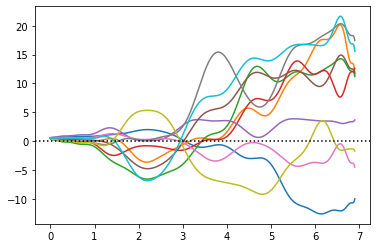

In [21]:
idxs = np.arange(0, soap_density.shape[0])
np.random.shuffle(idxs)
for i in idxs[0:10]:
    plt.plot(
        r_grid[soap_hyperparameters['radial_basis']], 
        dr * np.cumsum(np.sum(soap_density[i] * weight_density[0], axis=0)) + intercept
    )

plt.axhline(0, color='k', linestyle=':')
plt.show()

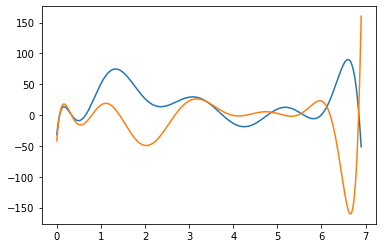

In [22]:
for n in range(0, n_species):
    plt.plot(r_grid[soap_hyperparameters['radial_basis']], weight_density[0, n])
plt.show()

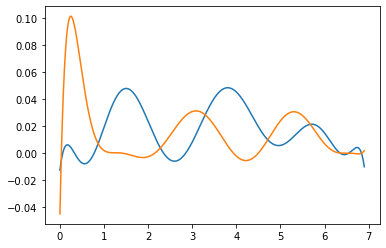

In [23]:
abs_soap_density = compute_soap_density(
    reshape_soaps(test_soaps, **reshape_args),
    **density_args
)

for n in range(0, n_species):
    plt.plot(r_grid[soap_hyperparameters['radial_basis']], abs_soap_density[0, n])
plt.show()